# Attacking the networks 
- using (random, degree, betweenness, closeness, and clustering based edges weight)

In [1]:
import pandas as pd 
import networkx as nx
import os
import random
from random import sample

def read_graph(N):
    G = nx.Graph()
    return nx.read_gml(f'Networks/{N}.gml')

names = [ 'dolphins',
          'polbooks',
          'word_adjacencies',
          'arenas-email',
             'Karate',
             'Erdos Renyi',
             'circuits s208',
             'circuits s420',
             'circuits s838',
             'E. coli',
             'Barabasi_albert_graph',
             'facebook 0',
             'facebook 107',
             'facebook 348',
             'facebook 414',
             'facebook 686',
             'facebook 1684',
             'bn-macaque-rhesus_brain_2',
             'soc-tribes',
             'fb-pages-food',
             'bn-cat-mixed-species_brain_1',
             'soc-firm-hi-tech']


# read the networks
networks = []
for N in names:
    network = {}
    network['name'] = N
    network['graph'] = read_graph(N)
    networks.append(network)
networks


[{'name': 'dolphins',
  'path': '/dolphins/dolphins.gml',
  'graph': <networkx.classes.graph.Graph at 0x7f5278676790>},
 {'name': 'polbooks',
  'path': '/polbooks/out2.txt',
  'graph': <networkx.classes.graph.Graph at 0x7f52786bf7c0>},
 {'name': 'word_adjacencies',
  'path': '/word_adjacencies.gml/word_adjacencies.gml',
  'graph': <networkx.classes.graph.Graph at 0x7f523ec3ee50>},
 {'name': 'arenas-email',
  'path': '/arenas-email/out2.txt',
  'graph': <networkx.classes.graph.Graph at 0x7f523ecf2460>},
 {'name': 'Karate',
  'path': 'Karate',
  'graph': <networkx.classes.graph.Graph at 0x7f5278676730>},
 {'name': 'Erdos Renyi',
  'path': 'Erdos Renyi',
  'graph': <networkx.classes.graph.Graph at 0x7f52786bf850>},
 {'name': 'circuits s208',
  'path': '/circuits/s208_st.txt',
  'graph': <networkx.classes.graph.Graph at 0x7f523ed640d0>},
 {'name': 'circuits s420',
  'path': '/circuits/s420_st.txt',
  'graph': <networkx.classes.graph.Graph at 0x7f52786bf5b0>},
 {'name': 'circuits s838',
  '

In [2]:
def plot(results, title):
    import matplotlib.pyplot as plt
    fig = plt.figure(dpi=600)
    fig, ax = plt.subplots()
    markers = ['+', 'x', 'o', 's', 'd', 'D', '*'] # Add your desired markers here
    for d in range(len(results)):
        data = results[d]
        x = [item[0] for item in data]
        y = [item[1] for item in data]
        marker_idx = d % len(markers) # Choose marker based on index of the result
        ax.plot(x, y, marker=markers[marker_idx], linewidth=0.5, markersize=3, label=names[d])

    ax.set_xlabel('edges')
    ax.set_ylabel(r'$|N_{LCC}| / |N| $')
    ax.set_title(f'{title}-based weighted edges')
    plt.legend()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [3]:
def weighted_edges(G, C):
    '''return a weighted edges'''
    W = []
    for u,v in G.edges():
        W.append([u, v, C[u]*C[v]])
    return sorted(W, key=lambda x: x[2])

def batch_list(lst):
    """
    Divide a list into batches of an equal number of items (as close to 50 as possible).
    """
    batch_size = (len(lst) + 49) // 50  # Calculate the batch size
    if batch_size==0:
        input(lst)
    num_batches = (len(lst) + batch_size - 1) // batch_size
    batches = [lst[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
    return batches

def simulation(centr):
    '''Idea: start removing edges from the network and measure the diameter'''
    results = []
    for network in networks:
        G = network['graph'].copy()
        bc_G = centr(G)                   # finding the centrality of the nodes
        W = weighted_edges(G, bc_G)       # weightening the edges

        batches = batch_list(W)             # sorting the edges based on their weight

        result = []
        for b in range(len(batches)):
            R = [(u,v) for u,v,_ in batches[b]] # edges to be removed...
            G.remove_edges_from(R)
            
            largest_component = G.subgraph(max(nx.connected_components(G), key=len))
            result.append([b, len(largest_component)/len(G)])
        results.append(result)
    return results


<Figure size 3840x2880 with 0 Axes>

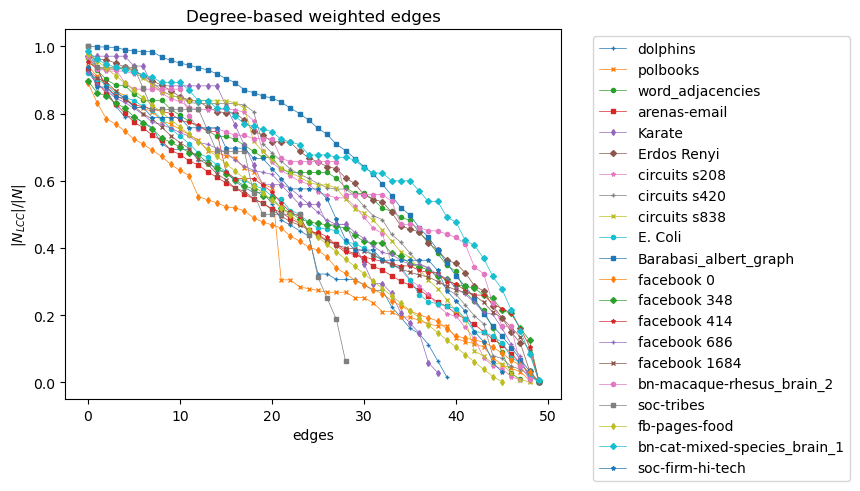

<Figure size 3840x2880 with 0 Axes>

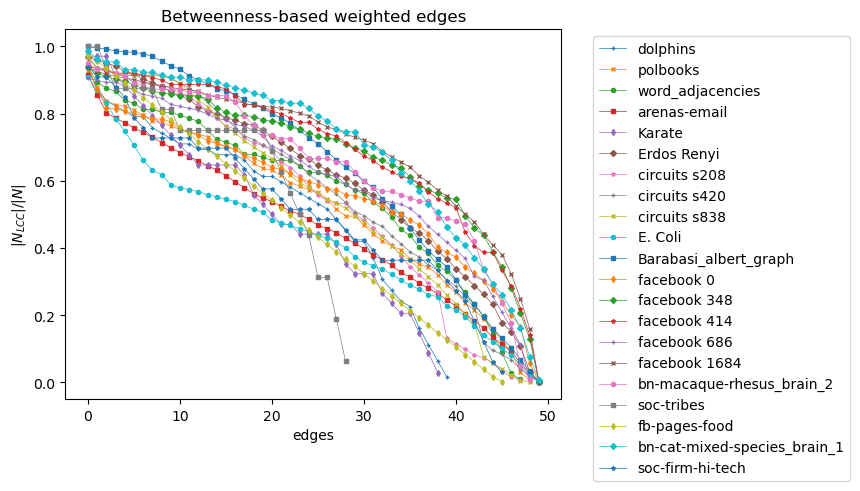

<Figure size 3840x2880 with 0 Axes>

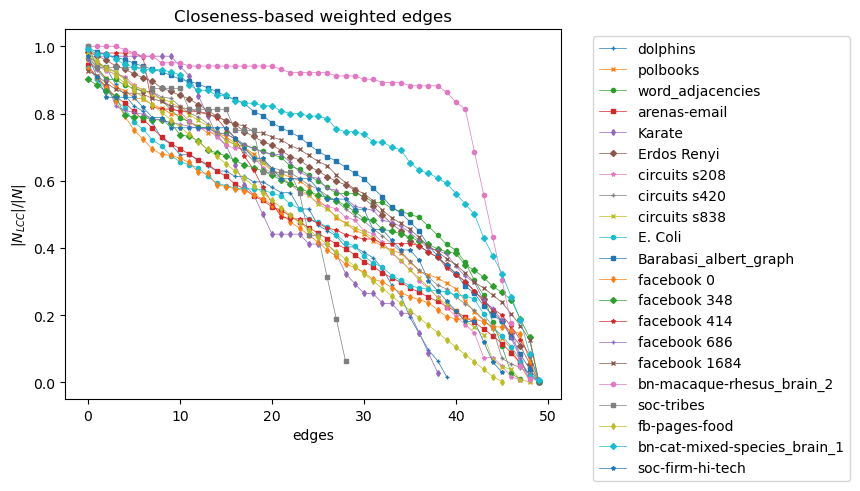

<Figure size 3840x2880 with 0 Axes>

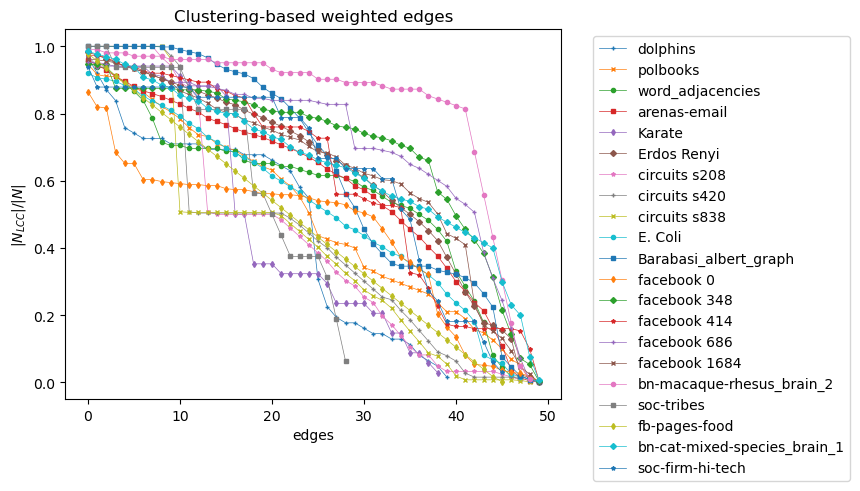

In [4]:
centralities = [nx.degree_centrality, nx.betweenness_centrality, nx.closeness_centrality, nx.clustering]
centr        = ['Degree'            ,   'Betweenness'          ,   'Closeness'          ,   'Clustering']
sims = {}
for i in range(4):
    cent = centr[i]
    sims[cent] = simulation(centralities[i])
    plot(sims[cent], cent)

<Figure size 3840x2880 with 0 Axes>

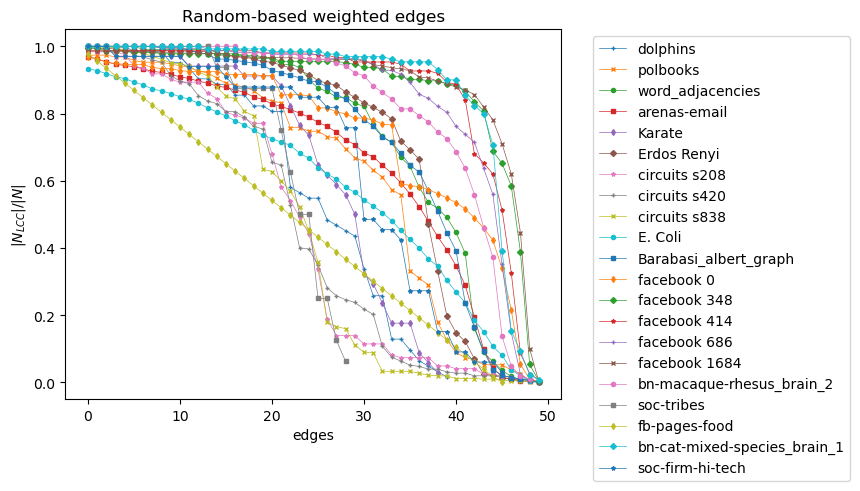

In [5]:
import random
def random_sim():
    results = []
    for network in networks:
        G = network['graph'].copy()              # original network
        E = list(G.edges())
        random.shuffle(E)
        W = batch_list(E)
        batches = batch_list(W)
        newBatches = []
        for b in batches:
            newBatches.append(b[0])
        result = []
        for b in range(len(newBatches)):
            G.remove_edges_from(newBatches[b])            
            largest_component = G.subgraph(max(nx.connected_components(G), key=len))
            result.append([b, len(largest_component)/len(G)])
        results.append(result)
    return results
rnd_results = random_sim()
plot(rnd_results, 'Random')



# Creating Regression Analysis table

<Figure size 3840x2880 with 0 Axes>

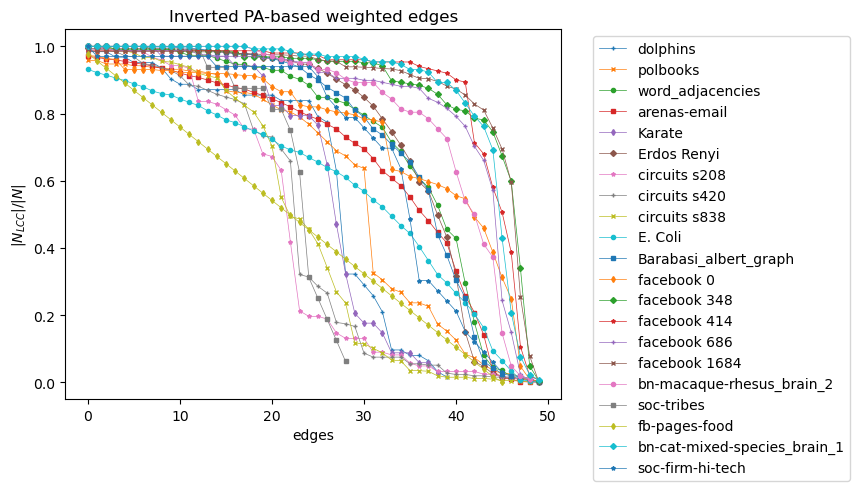

In [6]:
def simulation2():
    '''Implementing reverse preferential attachment'''
    results = []
    k = 0.01
    for network in networks:
        G = network['graph']
        d = nx.degree_centrality(G)
        W = [[u, v, (1/((d[u]+k)*(d[v]+k)))] for u,v in G.edges()]
        W = sorted(W, key=lambda x: x[2])
        batches = batch_list(W)

        result = []
        for b in range(len(batches)):
            R = [(u,v) for u,v,_ in batches[b]] # edges to be removed...
            G.remove_edges_from(R)
            largest_component = G.subgraph(max(nx.connected_components(G), key=len))
            result.append([b, len(largest_component)/len(G)])
        results.append(result)
    return results
iPA_results = random_sim()
plot(iPA_results, 'Inverted PA')

In [7]:
sims['random'] = rnd_results
sims['iPA']    = iPA_results


In [8]:
R = {}
R['Networks'] = names
for c in sims:
    print(c)
    Rs = []
    for i in range(len(names)):
        S   = sims[c][i]
        MAX = 0
        T   = 0
        for t, v in S:
            # t: time, v: value
            if v > MAX:
                MAX = v
            if v < MAX/2:
                T = t
                break
        Rs.append(T)
    R[c] = Rs
dfr = pd.DataFrame(R)
dfr

Degree
Betweenness
Closeness
Clustering
random
iPA


,Networks,Degree,Betweenness,Closeness,Clustering,random,iPA
0,dolphins,21,28,25,25,26,28
1,polbooks,21,31,28,25,35,31
2,word_adjacencies,36,34,37,38,39,39
3,arenas-email,24,27,24,35,37,37
4,Karate,26,21,20,18,30,27
5,Erdos Renyi,34,35,33,36,37,39
6,circuits s208,31,31,30,21,24,22
7,circuits s420,33,31,30,22,23,23
8,circuits s838,31,30,28,21,24,22
9,E. Coli,25,24,26,29,34,35


In [9]:
from networkx.algorithms.community import greedy_modularity_communities, girvan_newman
def properties(G):
    
    GCC = nx.transitivity(G)
    ACC = nx.average_clustering(G)
    d = nx.density(G)
    r = nx.degree_assortativity_coefficient(G)    
    lcg = sorted(nx.connected_components(G), key=len, reverse=True)
    LCG = G.subgraph(lcg[0])    
    ASP = nx.average_shortest_path_length(LCG)
    diam = nx.diameter(LCG)

    communities = greedy_modularity_communities(G)
    mod = nx.community.modularity(G, communities)
    eff = round(nx.global_efficiency(G), 12)
    return  GCC, ACC, d, r, ASP, diam, mod, eff

network_properties = [properties(g['graph']) for g in networks]

In [10]:
GCCs = [i for i, _,_,_,_,_,_,_ in network_properties]
ACCs = [i for _, i,_,_,_,_,_,_ in network_properties]
ds   = [i for _, _,i,_,_,_,_,_ in network_properties]
rs   = [i for _, _,_,i,_,_,_,_ in network_properties]
ASPs = [i for _, _,_,_,i,_,_,_ in network_properties]
diam = [i for _, _,_,_,_,i,_,_ in network_properties]
mod = [i for _, _,_,_,_,_,i,_ in network_properties]
eff  = [i for _, _,_,_,_,_,_,i in network_properties]

df2 = pd.DataFrame({'Networks': names, 
                    'GCC': GCCs, 
                    'ACC': ACCs,
                    'Density': ds, 
                    'r': rs, 
                    'ASP': ASPs,
                    'Diameter': diam, 
                    'M': mod, 
                    'e' : eff}) 
df2.to_csv('Data/networks properties.csv', index=False)

In [11]:
numeric_cols = df2.select_dtypes(include='number').columns
df_quartiles = df2[numeric_cols].apply(lambda x: pd.qcut(x.dropna(), 
                                                         q=[0, 0.25, 0.5, 0.75, 1.0], 
                                                         labels=False,
                                                        duplicates='drop') if x.dtype != object else x)
df_quartiles['Networks'] = df2['Networks']
df_quartiles

,GCC,ACC,Density,r,ASP,Diameter,M,e,Networks
0,1,1,2,1,2,2,2,1,dolphins
1,0,0,1,0,3,2,2,0,polbooks
2,1,1,2,1,1,0,0,2,word_adjacencies
3,0,0,0,0,3,3,3,0,arenas-email
4,1,2,3,0,0,0,1,3,Karate
5,0,0,0,2,2,1,1,1,Erdos Renyi
6,0,0,1,2,3,3,3,0,circuits s208
7,0,0,1,2,3,3,3,0,circuits s420
8,0,0,0,2,3,3,3,0,circuits s838
9,0,0,0,0,2,2,3,0,E. Coli


In [12]:
for i,j in [(0,0.25),(1, 0.5),(2, 0.75),(3, 1)]:
    df_quartiles = df_quartiles.replace(i,j)
df_quartiles

,GCC,ACC,Density,r,ASP,Diameter,M,e,Networks
0,0.50,0.50,0.75,0.50,0.75,0.75,0.75,0.50,dolphins
1,0.25,0.25,0.50,0.25,1.00,0.75,0.75,0.25,polbooks
2,0.50,0.50,0.75,0.50,0.50,0.25,0.25,0.75,word_adjacencies
3,0.25,0.25,0.25,0.25,1.00,1.00,1.00,0.25,arenas-email
4,0.50,0.75,1.00,0.25,0.25,0.25,0.50,1.00,Karate
5,0.25,0.25,0.25,0.75,0.75,0.50,0.50,0.50,Erdos Renyi
6,0.25,0.25,0.50,0.75,1.00,1.00,1.00,0.25,circuits s208
7,0.25,0.25,0.50,0.75,1.00,1.00,1.00,0.25,circuits s420
8,0.25,0.25,0.25,0.75,1.00,1.00,1.00,0.25,circuits s838
9,0.25,0.25,0.25,0.25,0.75,0.75,1.00,0.25,E. Coli


In [13]:
dfr1 = dfr.copy()
medians = dfr1.median()
print(medians)
for column in dfr1.columns :
    if column!= 'Networks':
        median = medians[column]  # Retrieve the median for the column
        dfr1[column] = (dfr1[column] > median).astype(int)
dfr1        

Degree         28.0
Betweenness    31.0
Closeness      30.0
Clustering     33.0
random         37.0
iPA            37.0
dtype: float64


/tmp/ipykernel_152277/3742336272.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  medians = dfr1.median()


,Networks,Degree,Betweenness,Closeness,Clustering,random,iPA
0,dolphins,0,0,0,0,0,0
1,polbooks,0,0,0,0,0,0
2,word_adjacencies,1,1,1,1,1,1
3,arenas-email,0,0,0,1,0,0
4,Karate,0,0,0,0,0,0
5,Erdos Renyi,1,1,1,1,0,1
6,circuits s208,1,0,0,0,0,0
7,circuits s420,1,0,0,0,0,0
8,circuits s838,1,0,0,0,0,0
9,E. Coli,0,0,0,0,0,0


In [14]:
Dataset = pd.merge(df_quartiles, dfr1, on='Networks')
Dataset = Dataset.reindex(columns = ['Networks', 'GCC', 'M', 'Density', 'r', 'e','ASP', 'Diameter', 'Degree',
       'Betweenness', 'Closeness', 'Clustering', 'random', 'iPA'])
Dataset

,Networks,GCC,M,Density,r,e,ASP,Diameter,Degree,Betweenness,Closeness,Clustering,random,iPA
0,dolphins,0.50,0.75,0.75,0.50,0.50,0.75,0.75,0,0,0,0,0,0
1,polbooks,0.25,0.75,0.50,0.25,0.25,1.00,0.75,0,0,0,0,0,0
2,word_adjacencies,0.50,0.25,0.75,0.50,0.75,0.50,0.25,1,1,1,1,1,1
3,arenas-email,0.25,1.00,0.25,0.25,0.25,1.00,1.00,0,0,0,1,0,0
4,Karate,0.50,0.50,1.00,0.25,1.00,0.25,0.25,0,0,0,0,0,0
5,Erdos Renyi,0.25,0.50,0.25,0.75,0.50,0.75,0.50,1,1,1,1,0,1
6,circuits s208,0.25,1.00,0.50,0.75,0.25,1.00,1.00,1,0,0,0,0,0
7,circuits s420,0.25,1.00,0.50,0.75,0.25,1.00,1.00,1,0,0,0,0,0
8,circuits s838,0.25,1.00,0.25,0.75,0.25,1.00,1.00,1,0,0,0,0,0
9,E. Coli,0.25,1.00,0.25,0.25,0.25,0.75,0.75,0,0,0,0,0,0


In [17]:
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score
from DA import pls_da1

data = Dataset.copy()
oldR = {}
X = data.loc[:, ['GCC', 'M', 'Density', 'r', 'Diameter', 'e','ASP']]
for c in [ 'Degree', 'Betweenness', 'Closeness', 'Clustering', 'random', 'iPA']:
    Y = data[c]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=19)
    oldR[c] = pls_da1(X_train, y_train, X_test).tolist()

oldR

/home/almusawiaf/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/home/almusawiaf/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/home/almusawiaf/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_f

{'Degree': [[-0.2311257446693406],
  [-0.1720568910918616],
  [-0.12082094671198755],
  [0.10008979991887465],
  [-0.0934400121740152],
  [-0.08847489362463101],
  [0.03060191431402406]],
 'Betweenness': [[-0.014326479541156739],
  [-0.20067359087692566],
  [-0.0701854068679351],
  [0.31514325053444187],
  [-0.06998094818926735],
  [-0.049354387002755774],
  [-0.005502150703921988]],
 'Closeness': [[-0.17627429982779974],
  [-0.2224844262603527],
  [-0.07114896521726867],
  [0.05894231301202279],
  [-0.1629294748500552],
  [-0.038463625585357895],
  [-0.0066894365714491874]],
 'Clustering': [[-0.024507024174890278],
  [-0.0945612493575533],
  [0.11798449772739691],
  [0.2538739358252918],
  [-0.1444711836313529],
  [-0.019575889499649432],
  [-0.033759283209229586]],
 'random': [[0.04092771451268814],
  [-0.10544137841782551],
  [0.0301296550400556],
  [0.18176994583596348],
  [-0.012861991107975028],
  [-0.0177430956926149],
  [-0.02406475534693025]],
 'iPA': [[-0.014326479541156739],

In [19]:
R = {c: [i[0] for i in oldR[c]] for c in oldR}
R['Measures'] = ['GCC', 'M', 'Density', 'r', 'e', 'Diameter','ASP']
result = pd.DataFrame(R)
result.to_csv('DA pruning.csv', index=False)
result

,Degree,Betweenness,Closeness,Clustering,random,iPA,Measures
0,-0.231126,-0.014326,-0.176274,-0.024507,0.040928,-0.014326,GCC
1,-0.172057,-0.200674,-0.222484,-0.094561,-0.105441,-0.200674,M
2,-0.120821,-0.070185,-0.071149,0.117984,0.030130,-0.070185,Density
3,0.100090,0.315143,0.058942,0.253874,0.181770,0.315143,r
4,-0.093440,-0.069981,-0.162929,-0.144471,-0.012862,-0.069981,e
5,-0.088475,-0.049354,-0.038464,-0.019576,-0.017743,-0.049354,Diameter
6,0.030602,-0.005502,-0.006689,-0.033759,-0.024065,-0.005502,ASP
